In [301]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import mygene

# Analysis of TCGA Tumor vs Normal Differential Expression

Using data produced from this experiment: <br>
https://github.com/jvivian/rnaseq-recompute-analysis/blob/master/experiments/tcga_matched.py 

### Number of samples

In [209]:
df = pd.DataFrame()

In [296]:
def zip_sort(x, y):
    vals = sorted(zip(x, y), key=lambda x: x[1])
    return zip(*vals)

def label_fix(l):
    return [x.replace('_', '\n').capitalize() for x in l]

def write_dict_list(d, directory):
    for x in d:
        if list(d[x]):
            with open(os.path.join(directory, x), 'w') as f:
                f.write('\n'.join(list(d[x])))

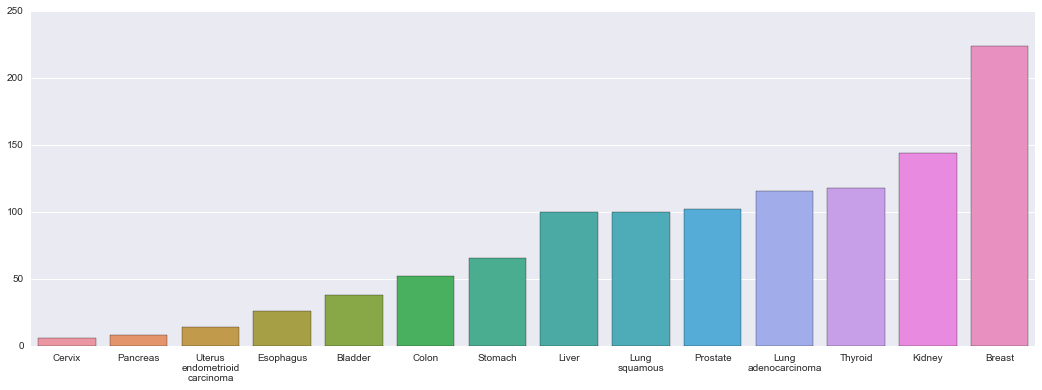

In [65]:
vector_names = [x.split('-vector')[0].replace('_', '\n').capitalize() for x in os.listdir('vectors/')]
num_samples = [len(open(os.path.join('vectors', x)).readlines()) for x in os.listdir('vectors/')]

vector_names, num_samples = zip_sort(vector_names, num_samples)

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(vector_names, num_samples, ax=ax);

In [213]:
df['num_samples'] = num_samples
df.index = [x.split('-vector')[0] for x in os.listdir('vectors/')]

### Significant Genes

Read in results from DESeq2 

In [44]:
result_paths = [x for x in os.listdir('results') if '.tsv' in x]
results = {}
for result in result_paths:
    results[result.split('-')[0]] = pd.read_csv(os.path.join('results', result), index_col=0, sep='\t')

In [83]:
results['cervix'].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geneId
ERN2,808.698620,6.019637,0.510330,11.795570,4.114042e-32,4.094957e-28,ENSG00000134398.12
NPIPA5,444.162577,3.866138,0.328321,11.775492,5.221162e-32,4.094957e-28,ENSG00000183793.13
SPDEF,308.176248,4.689188,0.506982,9.249228,2.261201e-20,1.182307e-16,ENSG00000124664.10
DNAH10,239.562672,3.391402,0.388675,8.725540,2.649128e-18,1.038856e-14,ENSG00000197653.14
MS4A8,359.864452,4.747871,0.546873,8.681859,3.893521e-18,1.221475e-14,ENSG00000166959.7


Collect sets of significant genes for each tissue

In [279]:
sig_genes = {x: results[x][results[x].padj < 0.05].index for x in [y.split('-')[0] for y in result_paths]}

Q: Number of significant genes for each tissue?

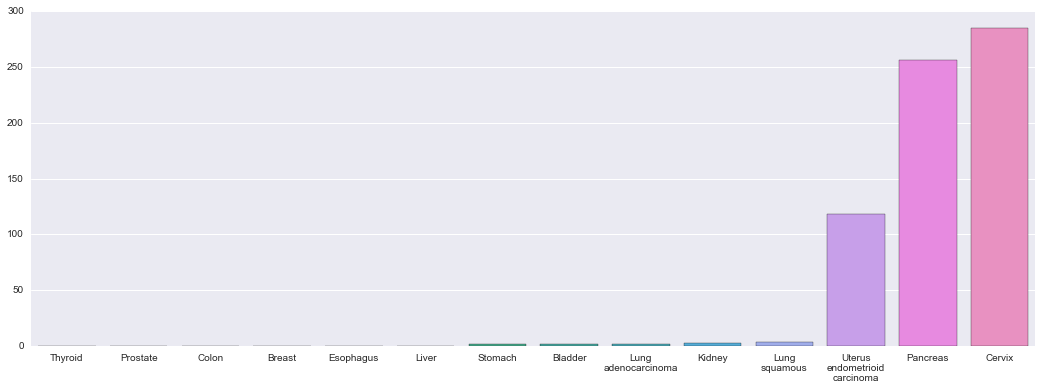

In [280]:
genes = [x.replace('_', '\n').capitalize() for x in sig_genes.keys()]
x, y = zip_sort(genes, [len(sig_genes[x]) for x in sig_genes.keys()])

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(x, y, ax=ax);

Save significant genes

In [297]:
write_dict_list(sig_genes, 'analysis/sig-genes/')

#### Is there a correlation between sample size and number of pvals?

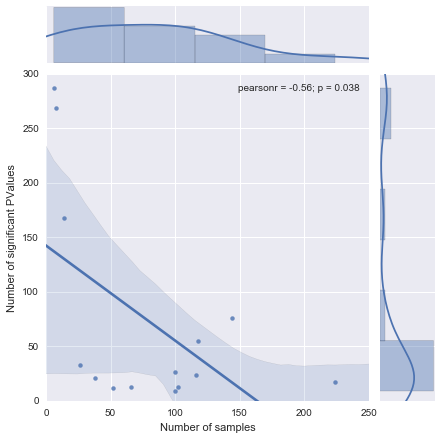

In [163]:
num_samples = np.array([len(open(os.path.join('vectors', x)).readlines()) for x in os.listdir('vectors/')])
num_pvals = np.array([len(results[x][results[x].pvalue < 0.001].index) for x in [y.split('-')[0] for y in result_paths]])

sns.jointplot(num_samples, num_pvals, kind='reg')
plt.ylabel('Number of significant PValues')
plt.xlabel('Number of samples')
plt.xlim([0, 250])
plt.ylim([0, 300]);

I was expecting a stronger correlation, but there does exist a slight relationship between number of samples and number of pvals.

In [100]:
padj = {x: results[x][results[x].padj < 0.1].index for x in [y.split('-')[0] for y in result_paths]} 
pval = {x: results[x][results[x].pvalue < 0.001].index for x in [y.split('-')[0] for y in result_paths]} 

### Overlap Heatmap

Collect top significant genes for every tissue

In [270]:
n = 100
top_hits = {x: results[x].head(n).index for x in [y.split('-')[0] for y in result_paths]} 

Save top hits

In [298]:
write_dict_list(top_hits, 'analysis/top-genes/')

Create 2D array of percentage overlap between all tissues

In [271]:
overlap = []
for tissue in df.index:
    overlap.append([float(len(set(top_hits[tissue]).intersection(set(top_hits[x]))))/n for x in df.index])
overlap = pd.DataFrame(overlap)
overlap.index = label_fix(df.index)
overlap.columns = label_fix(df.index)

Plot

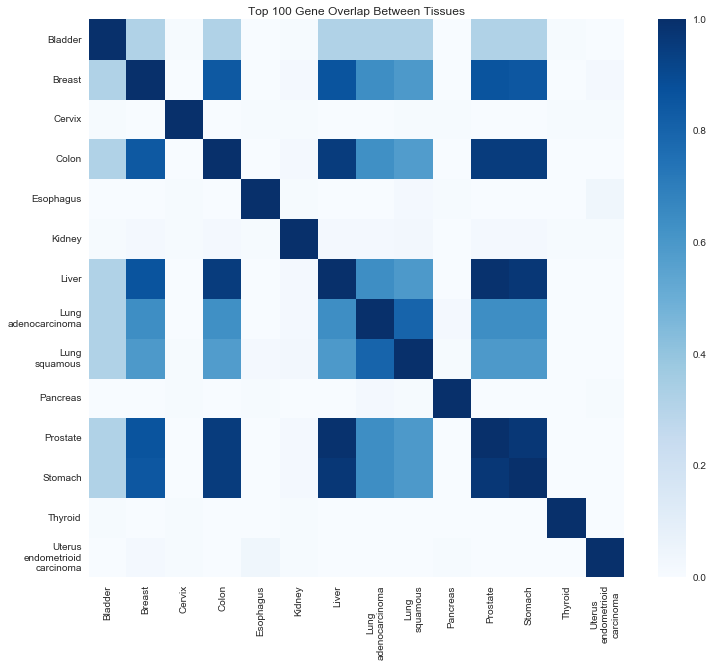

In [272]:
fig, ax = plt.subplots(figsize=[12,10])
sns.heatmap(overlap, ax=ax, cmap='Blues')
plt.title('Top {} Gene Overlap Between Tissues'.format(n));

In [225]:
df['overlap_sum'] = list(overlap.sum())

### Overlap and Sample Size

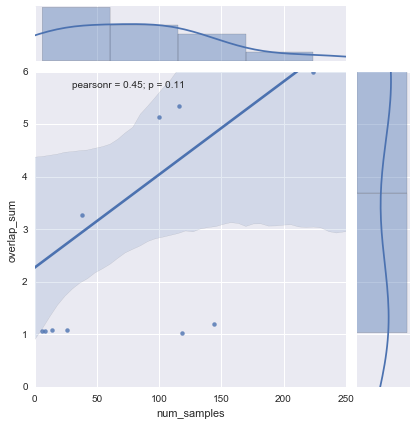

In [232]:
sns.jointplot('num_samples', 'overlap_sum', data=df, kind='reg')
plt.xlim([0, 250])
plt.ylim([0, 6]);

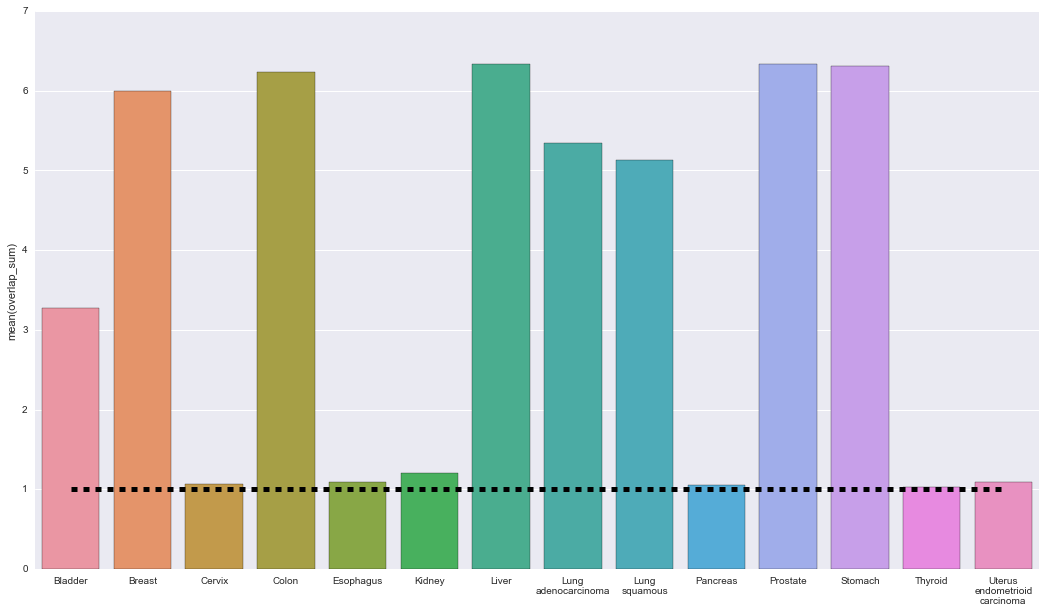

In [265]:
fig, ax = plt.subplbots(figsize=[18,10])
sns.barplot(x=label_fix(df.index), y=df.overlap_sum, ax=ax)
plt.plot([x for x in xrange(14)], [1 for x in xrange(14)], color='black', linestyle='dashed', linewidth=5);

In [269]:
df

,num_samples,overlap_sum
bladder,38,3.27
breast,224,6.00
cervix,6,1.07
colon,52,6.24
esophagus,26,1.09
kidney,144,1.20
liver,100,6.34
lung_adenocarcinoma,116,5.35
lung_squamous,100,5.13
pancreas,8,1.06


Most of the samples with a low number of samples correlate to a low number of gene overlap with other tissues, with the exception of Kidney and Thyroid. 

H: Tissues with low samples produce unique gene sets because there aren't enough samples to adequately handle the noise generated from the samples (with no technical replicates). 

### Gene Annotation

In [273]:
def get_basic_gene_info(gene_list):
    mg = mygene.MyGeneInfo()
    return mg.querymany(gene_list, 
                        scopes='symbol', 
                        fields='symbol,name,entrezgene,summary', 
                        species='human', 
                        returnall=True, 
                        as_dataframe=True, 
                        size=1)

Save basic annotation information

In [300]:
for t in top_hits:
    basic_info = get_basic_gene_info(top_hits[t])
    basic_info['out'].to_csv('analysis/annotations/' + t, sep='\t')

querying 1-100...done.
Finished.
querying 1-100...done.
Finished.
4 input query terms found no hit:
	[u'CCDC37', u'CCDC108', u'WI2-2610K16.2', u'LPPR3']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'CH507-396I9.6']
querying 1-100...done.
Finished.
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'CH507-396I9.6']
querying 1-100...done.
Finished.
4 input query terms found no hit:
	[u'AC004381.6', u'C14orf169', u'CCDC64', u'RP11-111M22.2']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'CH507-396I9.6']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'CH507-396I9.6']
querying 1-100...done.
Finished.
4 input query terms found no hit:
	[u'MT-ND6', u'C1orf95', u'MT-ND5', u'C6orf25']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'ERO1LB']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'C1orf110']
querying 1-100...done.
Finished.
1 input query terms found no 